# Computing vegetation index

---
From the satellite time-series, we calculate vegetation indices for each date and store this new information in a Data cube.
In a second step, we filter the cube in such a way as to only keep the images that seem useful.

---
## 1. Import librairies

In [3]:
import os

# xarray
import xarray as xr

---
## 2. Load of satellite time-series

### 2.1. NetCDF file to Xarray Dataset

We open the file created in the [previous notebook](01_array2files.ipynb).

In [7]:
startdate = "2018-01"
enddate = "2022-12"
output_dir = "output"

array = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}.nc')
    )

array

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 284, x: 398, time: 692)
Coordinates:
  * y            (y) float64 2kB 2.914e+06 2.914e+06 ... 2.911e+06 2.911e+06
  * x            (x) float64 3kB 3.952e+06 3.952e+06 ... 3.956e+06 3.956e+06
  * time         (time) datetime64[ns] 6kB 2018-01-01T10:54:41.026000 ... 202...
Data variables:
    spatial_ref  int32 4B ...
    B02          (time, y, x) float32 313MB ...
    B03          (time, y, x) float32 313MB ...
    B04          (time, y, x) float32 313MB ...
    B05          (time, y, x) float32 313MB ...
    B06          (time, y, x) float32 313MB ...
    B07          (time, y, x) float32 313MB ...
    B08          (time, y, x) float32 313MB ...
    B8A          (time, y, x) float32 313MB ...
    B11          (time, y, x) float32 313MB ...
    B12          (time, y, x) float32 313MB ...
    SCL          (time, y, x) float32 313MB ...

### 2.2. Filtering images according to SCL values

The Level-2A processing includes a Scene Classification and an Atmospheric Correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products. The Scene Classification (SCL) was developed to distinguish between cloudy pixels, clear pixels and water pixels of Sentinel-2 data and is a result of the Scene classification algorithm run by ESA. 

![fig_nrt](img/SCL.png)

For instance, we keep pixels values only related to the SCL classes: vegetation, non-vegetation and unclassified.
Then, we remove the SCL band for each variable in the data set.

In [8]:
cube = array.where(array.SCL.isin([4,5,7]))
cube = cube.drop_vars('SCL')
print(f"number of dates {len(cube.time)}")

number of dates 692


---

## 3. Computing vegetation indices (VI)

In [4]:
array['ndvi'] = (array.B8A - array.B04) / (array.B8A + array.B04)
array['ndmi'] = (array.B8A - array.B11) / (array.B8A + array.B11)
array['crswir'] = array.B11/(array.B8A+((array.B12-array.B8A)/(2185.7-864))*(1610.4-864))

# add 'grid_mapping' attribute to keep CRS coordinates (cf. export into netCDF)
array.ndvi.attrs = {'grid_mapping': 'spatial_ref'}
array.ndmi.attrs = {'grid_mapping': 'spatial_ref'}
array.crswir.attrs = {'grid_mapping': 'spatial_ref'}

array = array.drop_vars(['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'])

### 3.1. Apply cloud masks


In [5]:
# mask creation
cloud_mask = array.SCL.isin([3, 8, 9, 10])
array_mask = array.where(~cloud_mask)

### 3.2. Reducing the number of images (no cloud)

In [6]:
#array["filtre"] = array.SCL.isin([3, 8, 9, 10]).sum(dim=['x', 'y'])
#subset = array.where(array['filtre'] == 0, drop=True)

array_subset = array.where(cloud_mask.sum(dim=['x', 'y']) == 0, drop=True)
print(f"number of dates {len(array_subset.time)}")

number of dates 135


## 4. Plotting the VI time series

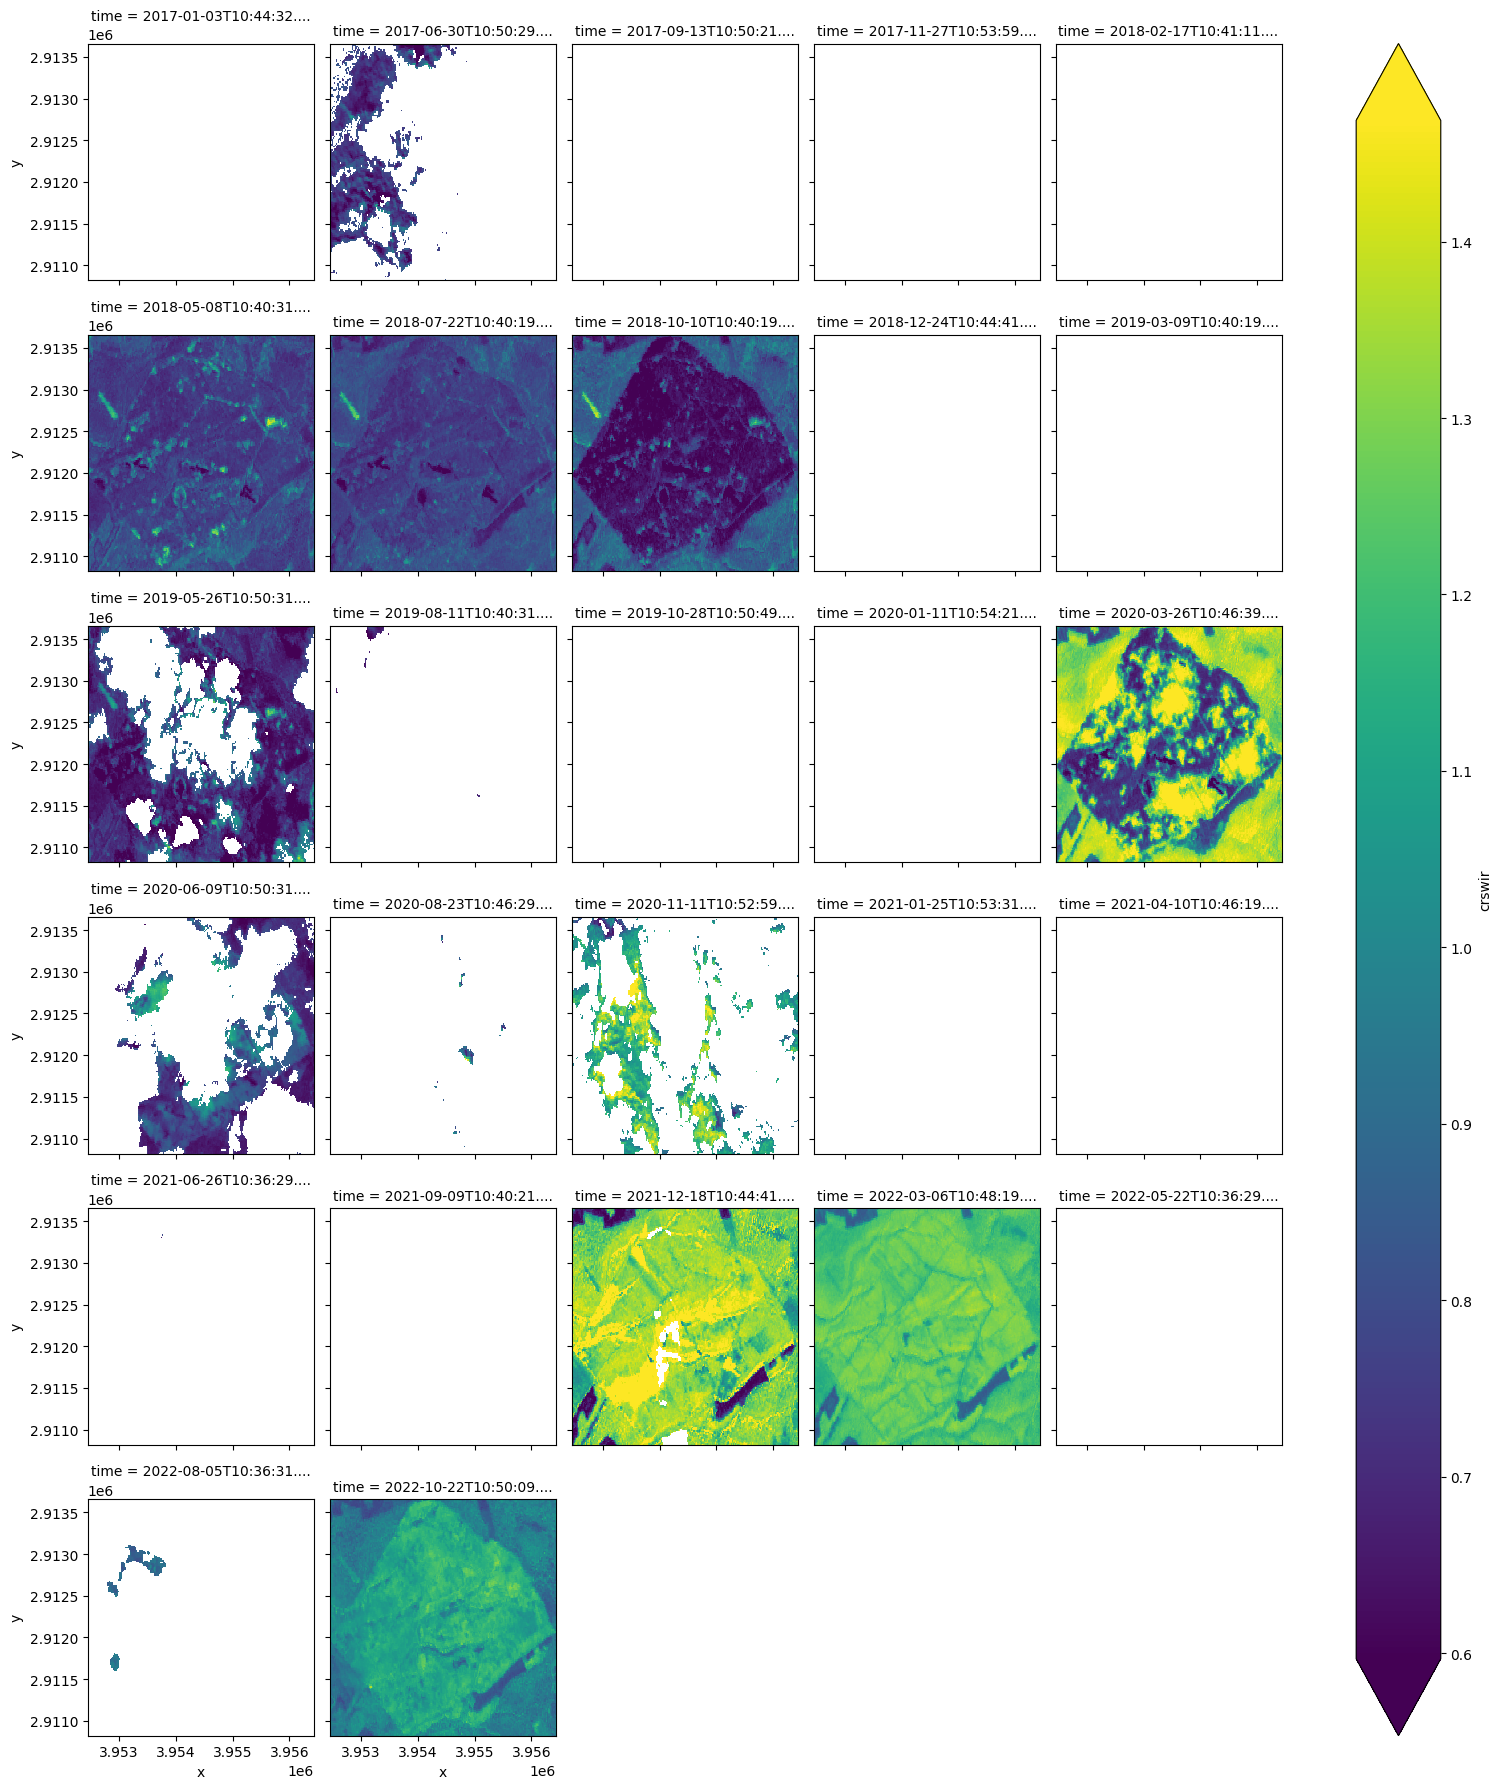

In [7]:
array_mask.crswir[::30].plot.imshow(col_wrap=5, col="time", robust=True, size=3)

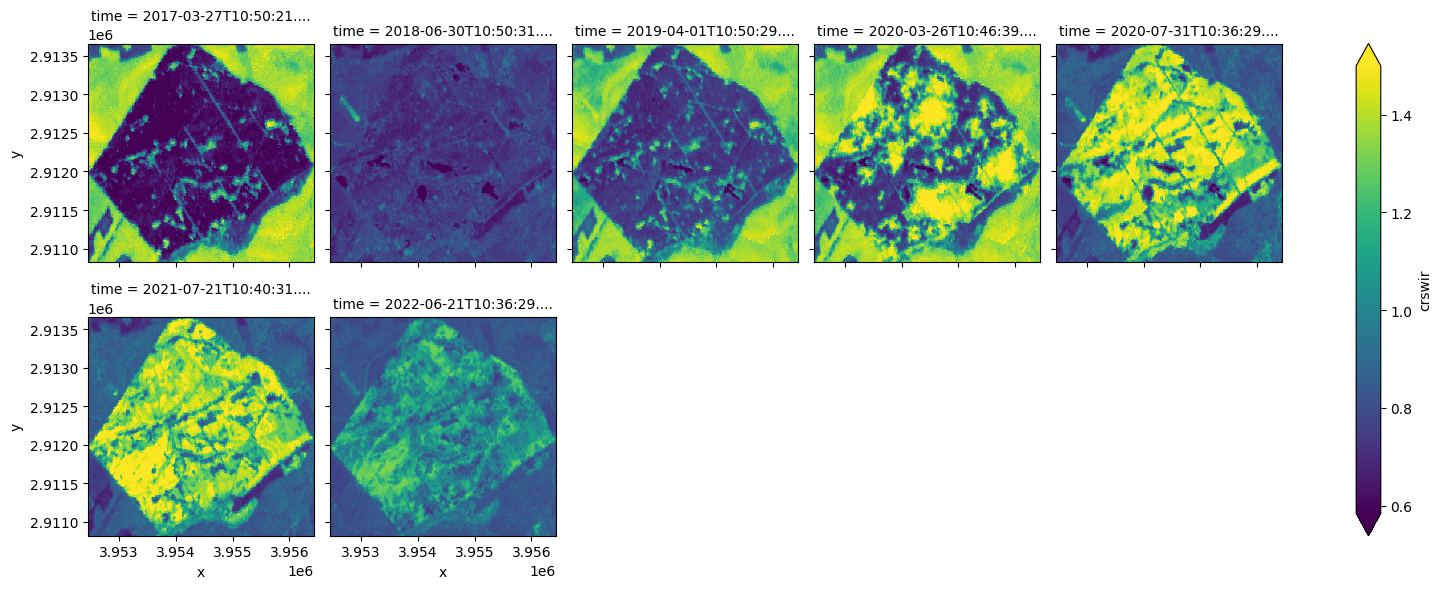

In [8]:
array_subset.crswir[::20].plot.imshow(col_wrap=5, col="time", robust=True, size=3)

## 5. Save time series as netCDF files
### 5.1. Save whole time series with cloud masked

In [9]:
array_mask.to_netcdf(
    f'data/S2TS_2017-01-2022-12_vi-mask.nc'
    )

### 5.2. Save partial time series without cloudy images

In [10]:
array_subset.to_netcdf(
    f'data/S2TS_2017-01-2022-12_vi-nocloud.nc'
    )